# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
conf.set("spark.executor.memory", "4g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [5]:
! hdfs dfs -copyFromLocal ../../data .

In [6]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2020-03-27 09:15 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2020-03-27 09:15 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2020-03-27 09:15 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2020-03-27 09:15 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2020-03-27 09:15 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2020-03-27 09:15 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2020-03-27 09:15 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2020-03-27 09:15 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2020-03-27 09:15 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [7]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [8]:
ratings = sc.textFile(RATINGS_PATH)

In [9]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [10]:
ratings.getNumPartitions()

5

In [11]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [12]:
ratings.count()

25000095

Количество пользователей

In [13]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 32.3 ms, sys: 10.4 ms, total: 42.7 ms
Wall time: 2min 50s


162541

Сохраним датасет в память

In [14]:
ratings = ratings.persist()

In [15]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 38.1 ms, sys: 12.8 ms, total: 50.8 ms
Wall time: 4min 34s


162541

Количество фильмов

In [16]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [67]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [68]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [19]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [20]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2020-03-27 09:32 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58903 2020-03-27 09:32 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112361 2020-03-27 09:32 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131524 2020-03-27 09:32 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114377 2020-03-27 09:32 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133576 2020-03-27 09:32 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117783 2020-03-27 09:32 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143242 2020-03-27 09:32 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     131984 2020-03-27 09:32 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167729 2020-03-27 09:32 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [21]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [22]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [23]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

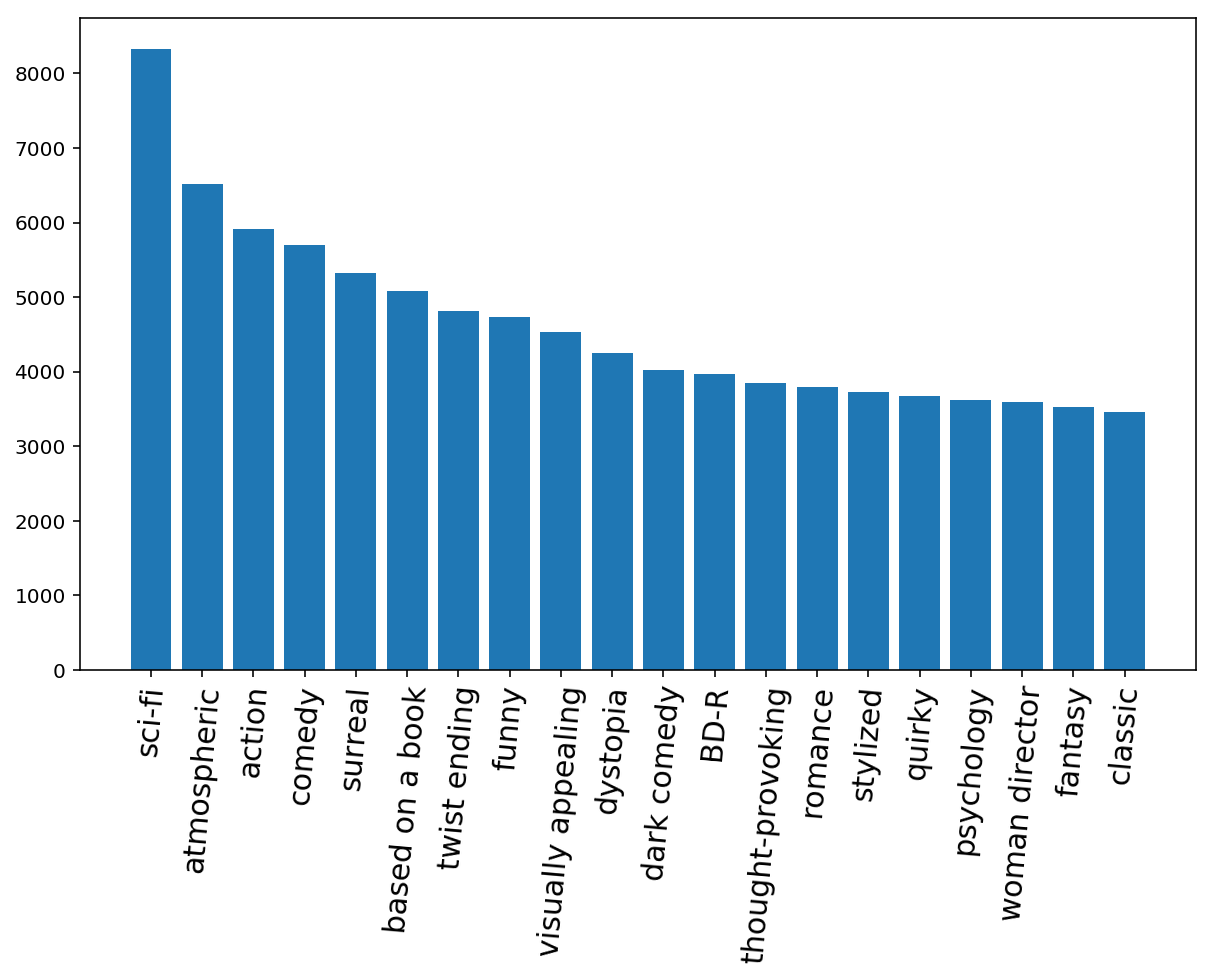

In [24]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [39]:
ratings_number = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies)

ratings_number \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .map(lambda key_value: (key_value[1][1][1], key_value[1][0])) \
    .take(10)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [43]:
number_5 = ratings \
    .filter(lambda r: r.rating == 5.0) \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies)

number_5 \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .map(lambda key_value: (key_value[1][1][1], key_value[1][0])) \
    .take(10)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [44]:
from matplotlib.pyplot import hist

(array([  680.,   991.,  1875.,  4166.,  7817., 15596., 16903.,  8613.,
         1475.,   931.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <a list of 10 Patch objects>)

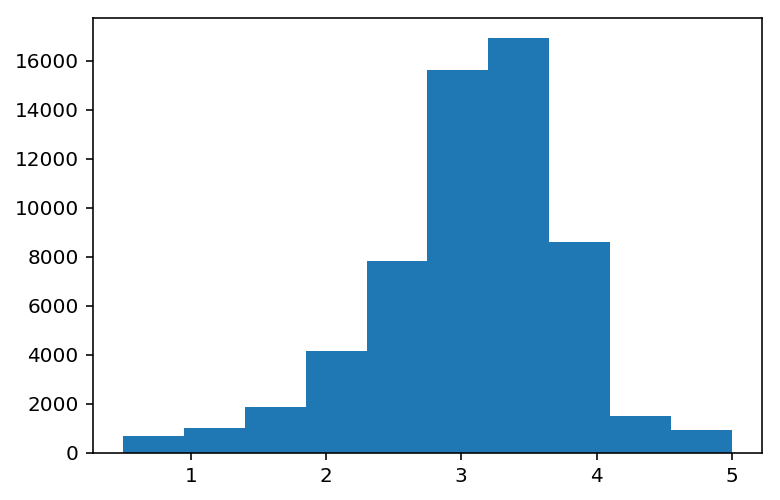

In [46]:
hist(movie_avg_rating.map(lambda key_value: key_value[1]).collect())

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

(array([5.530e+04, 1.341e+03, 5.940e+02, 3.440e+02, 2.670e+02, 1.870e+02,
        1.430e+02, 1.170e+02, 1.010e+02, 7.600e+01, 7.600e+01, 5.900e+01,
        5.000e+01, 4.900e+01, 3.500e+01, 2.900e+01, 2.400e+01, 1.900e+01,
        2.300e+01, 1.800e+01, 1.300e+01, 1.400e+01, 2.100e+01, 9.000e+00,
        1.300e+01, 6.000e+00, 8.000e+00, 1.200e+01, 5.000e+00, 6.000e+00,
        7.000e+00, 8.000e+00, 3.000e+00, 1.200e+01, 1.000e+00, 3.000e+00,
        6.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 5.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00]),
 array

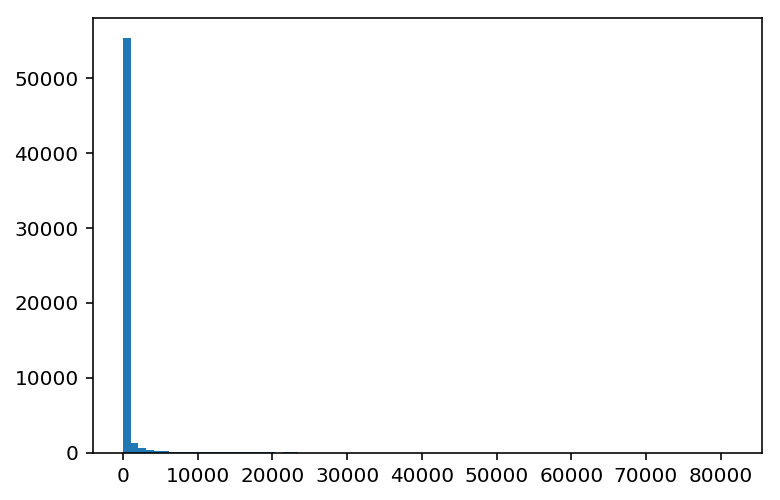

In [49]:
hist(ratings_number.map(lambda key_value: key_value[1][0]).collect(), bins=80)

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

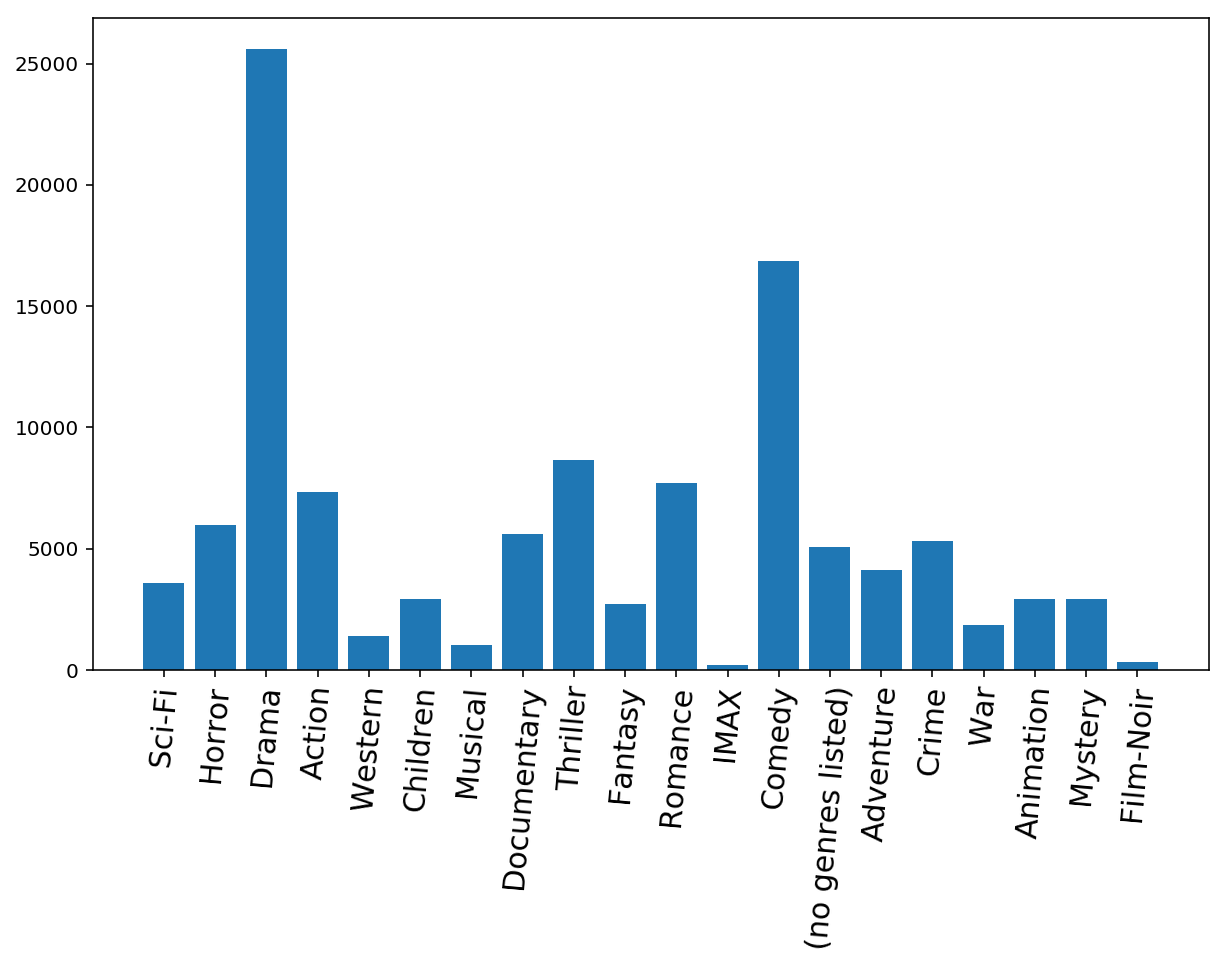

In [84]:
movies = sc.textFile(MOVIES_PATH)
genres = movies \
    .map(lambda s: (s.split(',')[0], s.split(',')[-1])) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0])) \
    .flatMap(lambda key_value: [(key_value[0], genre) for genre in key_value[1][1].split('|')])

genres_number = genres \
    .map(lambda key_value: (key_value[1], 1)) \
    .reduceByKey(lambda a, b: a + b)

keys, values = zip(*genres_number.collect())

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [159]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')

movies = sc.textFile(MOVIES_PATH)
movies = movies \
    .map(lambda s: (s.split(',')[:2])) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

links = sc.textFile(LINKS_PATH)
links = links \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[2].isdigit()) \
    .keyBy(lambda arr: int(arr[2]))

links.take(5)

[(862, ['1', '0114709', '862']),
 (8844, ['2', '0113497', '8844']),
 (15602, ['3', '0113228', '15602']),
 (31357, ['4', '0114885', '31357']),
 (11862, ['5', '0113041', '11862'])]

In [164]:
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')
info = sc.textFile(TMDB_PATH)
actors = info \
    .map(lambda s: json.loads(s)) \
    .filter(lambda js: 'id' in js) \
    .map(lambda js: (js['id'], js['casts']['cast'])) \
    .flatMap(lambda key_value: [(key_value[0], (value['name'], value['id'])) for value in key_value[1]])

t_hanks = actors \
    .filter(lambda arr: (arr[1][0] == 'Tom Hanks' and arr[1][1] == 31)) \
    .keyBy(lambda arr: arr[0]) \
    .join(links) \
    .map(lambda arr: (int(arr[1][1][0]), arr[1][0][1][0])) \
    .keyBy(lambda arr: arr[0]) \
    .join(movies) \
    .map(lambda arr: (arr[0], arr[1][1][1], arr[1][0][1]))

t_hanks.collect()

[(539, 'Sleepless in Seattle (1993)', 'Tom Hanks'),
 (581, '"Celluloid Closet', 'Tom Hanks'),
 (117684, 'Elvis Has Left the Building (2004)', 'Tom Hanks'),
 (2072, '"\'burbs', 'Tom Hanks'),
 (2100, 'Splash (1984)', 'Tom Hanks'),
 (183043, 'Every Time We Say Goodbye (1986)', 'Tom Hanks'),
 (3255, '"League of Their Own', 'Tom Hanks'),
 (105504, 'Captain Phillips (2013)', 'Tom Hanks'),
 (106022, 'Toy Story of Terror (2013)', 'Tom Hanks'),
 (73472, 'Shooting War (2000)', 'Tom Hanks'),
 (107352, 'Killing Lincoln (2013)', 'Tom Hanks'),
 (1, 'Toy Story (1995)', 'Tom Hanks'),
 (132070, 'And the Oscar Goes To... (2014)', 'Tom Hanks'),
 (3130, 'Bonfire of the Vanities (1990)', 'Tom Hanks'),
 (4012, 'Punchline (1988)', 'Tom Hanks'),
 (4677, 'Turner & Hooch (1989)', 'Tom Hanks'),
 (54272, '"Simpsons Movie', 'Tom Hanks'),
 (87522, 'Larry Crowne (2011)', 'Tom Hanks'),
 (195063, 'Magnificent Desolation: Walking on the Moon (2005)', 'Tom Hanks'),
 (115879, 'Toy Story Toons: Small Fry (2011)', 'Tom Han

In [173]:
popular_actors = actors \
    .keyBy(lambda arr: arr[1][0]) \
    .map(lambda arr: (arr[0], 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda arr: arr[1], ascending=False)

popular_actors.take(5)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [200]:
from datetime import datetime

datas = info \
    .map(lambda s: json.loads(s)) \
    .filter(lambda js: 'id' in js) \
    .map(lambda js: (js['id'], js['release_date'])) \
    .keyBy(lambda arr: arr[0]) \
    .join(links) \
    .map(lambda arr: (int(arr[1][1][0]), arr[1][0][1])) \
    .keyBy(lambda arr: arr[0]) \
    .join(genres) \
    .filter(lambda arr: arr[1][0][1]) \
    .map(lambda arr: ((int(arr[1][0][1][:4]), arr[1][1]), 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .filter(lambda arr: arr[0][1] != '(no genres listed)') \
    .sortBy(lambda arr: arr[0])
    
datas.take(10)

[((1874, 'Documentary'), 1),
 ((1881, 'Documentary'), 1),
 ((1888, 'Documentary'), 4),
 ((1890, 'Comedy'), 1),
 ((1891, 'Action'), 1),
 ((1891, 'Documentary'), 4),
 ((1892, 'Animation'), 1),
 ((1894, 'Comedy'), 3),
 ((1894, 'Documentary'), 14),
 ((1894, 'Drama'), 1)]

In [228]:
genres = datas \
    .map(lambda arr: arr[0][1]) \
    .distinct() \
    .collect()

In [225]:
years = datas \
    .map(lambda arr: arr[0][0]) \
    .distinct() \
    .sortBy(lambda arr: arr)

x = years.collect()

In [203]:
result = datas.collect()

In [230]:
import pandas as pd
stacks = pd.DataFrame(index=genres, columns=x)

In [231]:
for res in result:
    stacks.loc[res[0][1], res[0][0]] = res[1]

In [232]:
stacks = stacks.fillna(0)

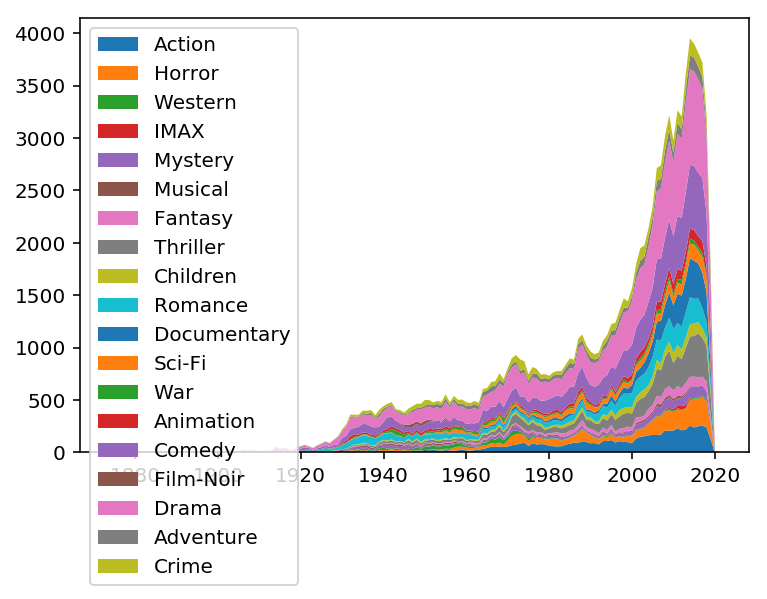

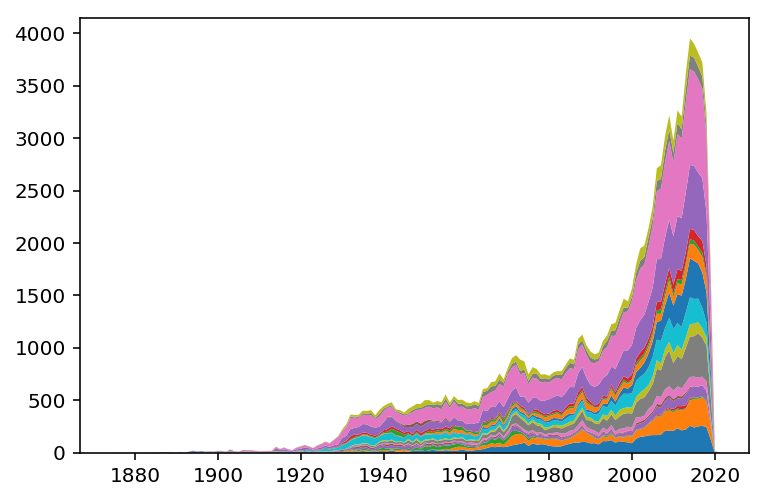

In [233]:
fig, ax = plt.subplots()
ax.stackplot(x, stacks.values, labels=genres)
ax.legend(loc='upper left')
plt.show()

fig, ax = plt.subplots()
ax.stackplot(x, stacks.values)
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [241]:
movies = sc.textFile(MOVIES_PATH)
genres = movies \
    .map(lambda s: (s.split(',')[0], s.split(',')[-1])) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0])) \
    .flatMap(lambda key_value: [(key_value[0], genre) for genre in key_value[1][1].split('|')])

genres.take(10)

[(1, 'Adventure'),
 (1, 'Animation'),
 (1, 'Children'),
 (1, 'Comedy'),
 (1, 'Fantasy'),
 (2, 'Adventure'),
 (2, 'Children'),
 (2, 'Fantasy'),
 (3, 'Comedy'),
 (3, 'Romance')]

In [275]:
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')
info = sc.textFile(TMDB_PATH)
mean_values = info \
    .map(lambda s: json.loads(s)) \
    .filter(lambda js: 'id' in js) \
    .map(lambda js: (js['id'], js['revenue'], js['budget'])) \
    .filter(lambda arr: arr[1] != 0 and arr[2] != 0) \
    .keyBy(lambda arr: arr[0]) \
    .join(links) \
    .map(lambda arr: (int(arr[1][1][0]), arr[1][0][1], arr[1][0][2])) \
    .keyBy(lambda arr: arr[0]) \
    .join(genres) \
    .map(lambda arr: (arr[1][0][1], arr[1][0][2], 1, arr[1][1])) \
    .keyBy(lambda arr: arr[3]) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2])) \
    .mapValues(lambda arr: (arr[0] / arr[2], arr[1] / arr[2]))

In [276]:
mean_values.take(5)

[('Action', (153913041.26964855, 51917028.453035146)),
 ('Horror', (60568722.51457726, 18121391.31632653)),
 ('Western', (51673488.08737864, 28319123.932038836)),
 ('IMAX', (477667980.442953, 133160134.22818792)),
 ('Mystery', (76402971.55528255, 27127235.88943489))]

In [279]:
roi = mean_values \
    .mapValues(lambda arr: arr[0]/arr[1])

roi.take(5)

[('Action', 2.964596508231984),
 ('Horror', 3.342388090257047),
 ('Western', 1.8246852625591943),
 ('IMAX', 3.587169562508883),
 ('Mystery', 2.8164672533053334)]

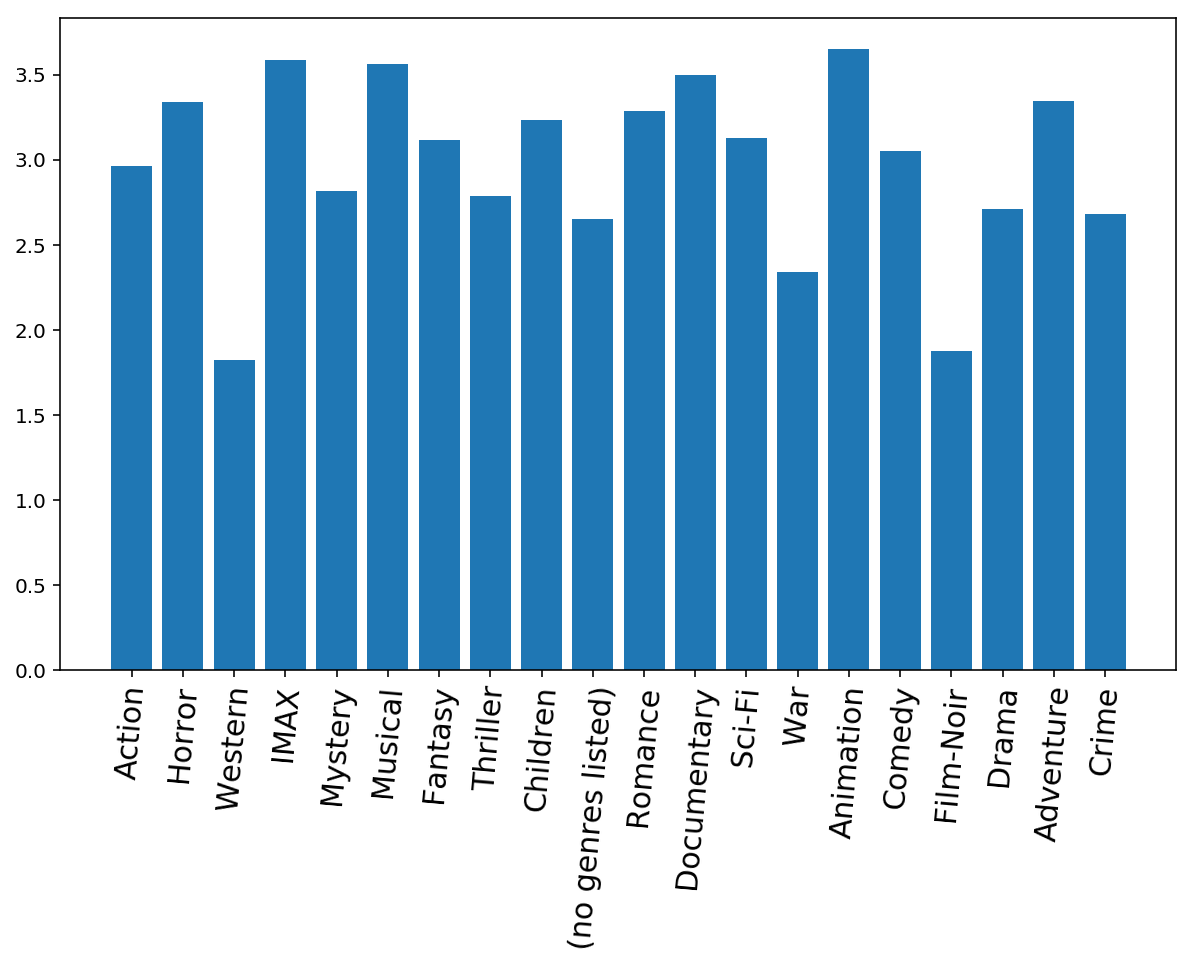

In [280]:
keys, values = zip(*roi.collect())

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()